
    
    Subject: Structured data learning with Wide, Deep, and Cross networks

    Author: zerojin
    Date created: 2021/08/19
    Last modified: 2021/00/20
    Licence: Academic Free License

    Status: Development
    Version: 0.01

    Python Version: 3.7.11
    tensorflow Version: 2.6.0

## Introduction

아래 예제에서는 두개의 모델을 사용하여 정형 데이터의 분류 문제를 해결하는 방법론을 설명함:

1. [Wide & Deep Learning: Better Together with TensorFlow models](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) - Google AI Blog
2. [Deep & Cross Network for Ad Click Predictions](https://arxiv.org/abs/1708.05123) - Paper

3. [Improved Deep & Cross Network and Practical Lessons
for Web-scale Learning to Rank Systems](https://arxiv.org/pdf/2008.13535.pdf) - Paper

해당 예제는 TensorFlow 2.5 이상의 버전에서 실행됨.

## The dataset

예제에서는 UCI Machine Learning Repository에서 제공하는 [Covertype](https://archive.ics.uci.edu/ml/datasets/covertype) dataset을 사용함. Covertype Dataset은 수종 데이터로 지도상의 영역의 특징(cartographic variables)으로부터 대표적인 나무의 종류(forest cover type)를 분류하는 문제임. 데이터의 표본은 506,011으로 12개의 설명변수(10개의 연속형 변수와 2개의 카테고리 변수)를 가지고 있음. 개별 샘플당 1부터 7까지 7개 종류로 분류됨.

## Importing Modules

In [ ]:
import sys 
import math
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup

print('system version: ', sys.version)
print('tensor version: ', tf.__version__)
print('NumPy version: ', np.__version__)
print('Pandas version: ', pd.__version__)

system version:  3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
tensor version:  2.6.0
NumPy version:  1.19.5
Pandas version:  1.1.5


## Prepare the data

우선, UCI Machine Learning Repository에서 Pandas를 통해 Dataset을 불러옴

In [ ]:
data_url = (
            "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
            )
raw_data = pd.read_csv(data_url, header=None)
print(f"Dataset shape: {raw_data.shape}")
raw_data.head()

Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


Dataset에 있는 두개의 카테고리 변수는 0과 1로 분류된 변수이며 우리는 카테고리 변수를 대표적인 방법으로 변환하여 하나의 정수형 값으로 만들고자 함.

In [ ]:
# soil_type_values
# 14~53번 재 변수들 중 1의 값을 가지고 있으면 해당 라벨을 부여
raw_data.loc[:, 14:53].sum(axis=1).value_counts()

1    581012
dtype: int64

In [ ]:
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]


wilderness_area = raw_data.loc[:, 10:13].apply(lambda x:wilderness_area_values[x.to_numpy().nonzero()[0][0]], axis=1)
soil_type = raw_data.loc[:, 14:53].apply(lambda x:soil_type_values[x.to_numpy().nonzero()[0][0]], axis=1)


CSV_HEADER = [
            "Elevation",
            "Aspect",
            "Slope",
            "Horizontal_Distance_To_Hydrology",
            "Vertical_Distance_To_Hydrology",
            "Horizontal_Distance_To_Roadways",
            "Hillshade_9am",
            "Hillshade_Noon",
            "Hillshade_3pm",
            "Horizontal_Distance_To_Fire_Points",
            "Wilderness_Area",
            "Soil_Type",
            "Cover_Type",
             ]


data = pd.concat(
                 [
                  raw_data.loc[:, 0:9], 
                  wilderness_area, 
                  soil_type, 
                  raw_data.loc[:, 54]
                  ],
                 axis=1,
                 ignore_index=True,
                )
data.columns = CSV_HEADER

# label index를 0 부터 진행하기 위해 -1
data["Cover_Type"] = data["Cover_Type"] - 1

print(f"Dataset shape: {data.shape}")
data.head().T

Dataset shape: (581012, 13)


,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


데이터 변환을 통해 만들어진 Dataset은 12개의 독립 변수와 1개의 종속 변수로 구성됨.  
분석을 위해 Dataset 중 85%를 학습 데이터로 15%를 평가 데이터로 사용함.

In [ ]:
# 라벨의 분포가 다양
# 일반화 성능을 높히기 위해 각 층별 동이한 비율로 train/test 나누는게 필요
# 각 층화 무작위 표본 추출이 필요
data['Cover_Type'].value_counts()

1    283301
0    211840
2     35754
6     20510
5     17367
4      9493
3      2747
Name: Cover_Type, dtype: int64

!["층화무작위표본추출"](https://t1.daumcdn.net/cfile/tistory/99785E3F5E48AEC50A)

In [ ]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 493927
Test split size: 87085


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
 
 
split_fn = StratifiedShuffleSplit(
                                  n_splits=1, 
                                  test_size=0.15,
                                  random_state=1004,
                                  )
 
 
for train_idx, test_idx in split_fn.split(data, data['Cover_Type']):
    train_data = data.iloc[train_idx,:]
    test_data = data.iloc[test_idx,:]
 
 
print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")

Train split size: 493860
Test split size: 87152


다음으로 학습 데이터와 평가 데이터를 각각 CSV로 저장함.

In [ ]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"


train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

## Define dataset metadata

이제, 입력 Dataset을 불러오고, 해석하고, 인코딩한 데이터를 유용하게 사용하기 위해 metadata를 생성하고자 함.

In [ ]:
TARGET_FEATURE_NAME = "Cover_Type"
TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]
NUMERIC_FEATURE_NAMES = [
                        "Aspect",
                        "Elevation",
                        "Hillshade_3pm",
                        "Hillshade_9am",
                        "Hillshade_Noon",
                        "Horizontal_Distance_To_Fire_Points",
                        "Horizontal_Distance_To_Hydrology",
                        "Horizontal_Distance_To_Roadways",
                        "Slope",
                        "Vertical_Distance_To_Hydrology",
                        ]
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
                                        "Soil_Type": list(data["Soil_Type"].unique()),
                                        "Wilderness_Area": list(data["Wilderness_Area"].unique()),
                                        }
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
COLUMN_DEFAULTS = [
                   [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
                   for feature_name in CSV_HEADER
                 ]  # 연속형 변수에 속한 변수일 경우 0, 아닐 경우 NA
NUM_CLASSES = len(TARGET_FEATURE_LABELS)

## Experiment setup

다음으로, 데이터를 읽고 해석(parsing)한 다음에 학습가 평가를 하기 위해 [`tf.data.Dataset`](https://www.tensorflow.org/guide/datasets)을 사용한 함수를 정의하고자 함.

In [ ]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
                                                    csv_file_path,
                                                    batch_size=batch_size,
                                                    column_names=CSV_HEADER,
                                                    column_defaults=COLUMN_DEFAULTS,
                                                    label_name=TARGET_FEATURE_NAME,
                                                    num_epochs=1,
                                                    header=True,
                                                    shuffle=shuffle,
                                                    )
    return dataset.cache()

# .cache() : 데이터셋을 메모리 또는 로컬 저장소에 캐시할 수 있습니다. 
# 이렇게하면 각 에포크 동안 실행되는 일부 작업(파일 열기 및 데이터 읽기 등)이 저장됩니다.

다음으로 parameters를 정의하고 모델 학습과 평가를 진행하는 절차를 소개함.


In [ ]:
# define parameters 
learning_rate = 0.001 
dropout_rate = 0.1 
batch_size = 265
num_epochs = 2
hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[keras.metrics.SparseCategoricalAccuracy()],
                  )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
                        train_dataset, 
                        epochs=num_epochs,
                        )
    print("Model training finished")

    _, accuracy = model.evaluate(
                                 test_dataset, 
                                 verbose=0,
                                 )

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

## Create model inputs

모델의 입력 정보를 Dictionary를 통해 정의함.   
Dictonary에 입력할 때 Key는 변수명이고 Value는 `keras.layers.Input`을 통해 tensor의 자료형태와 크기를 입력합니다.

In [ ]:
# 두개 이상의 input을 받을 경우 dictionary를 통해 Inpuy layer를 정의해야 함
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                                                name=feature_name, 
                                                shape=(), 
                                                dtype=tf.float32,
                                                )
        else:
            inputs[feature_name] = layers.Input(
                                                name=feature_name, 
                                                shape=(), 
                                                dtype=tf.string,
                                                )
    return inputs

## Encode features

입력 데이터에서 두개의(sparse, dense) 대표 표현을 만듦:  
1. **희소 표현(sparse representation)**, `CategoryEncoding` layer를 사용하여 categorical 변수를 one-hot 인코딩함. **희소 표현(sparse representation)**은 모델이 모든 변수 값들의 빈발도를 학습하여 *memorize*하는데 도움을 줌.


2. **밀집 표현(dense representation)**, `Embedding` layer를 사용하여 categorycal 변수를 저차원으로 임베딩함. **밀집 표현(dense representation)**은 모델이 학습하지 못한 특징들의 조합을 보다 잘 학습시켜 *generalize* 하는데 도움을 줌.

In [ ]:
def encode_inputs(inputs, use_embedding=False):
    
    encoded_features = [] # 데이터 모음
    
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name] # 범주 종류 탐색        
            lookup = StringLookup( 
                                  vocabulary=vocabulary,
                                  mask_token=None,
                                  num_oov_indices=0,
                                  output_mode="int" if use_embedding else "binary",
                                 ) # labelencoder, tensor output
            if use_embedding:
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                embedding = layers.Embedding(
                                            input_dim=len(vocabulary), 
                                            output_dim=embedding_dims,
                                            )
                encoded_feature = embedding(encoded_feature) # (batch_size, embedding_dims)
            else:
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1)) # one-hot encoding
        else:
            encoded_feature = tf.expand_dims(inputs[feature_name], -1) # (batch_size, 1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)

    return all_features

## Experiment 1: a baseline model

categorical 변수를 one-hot 인코딩하고 가장 기본적인 *a multi-layer feed-forward network*를 통해 학습을 진행함.


In [ ]:
def create_baseline_model():
    # Define input data type & shape & size 
    inputs = create_model_inputs()

    # Modeling
    features = encode_inputs(inputs)
    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)
    
    # output
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    
    # model build
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

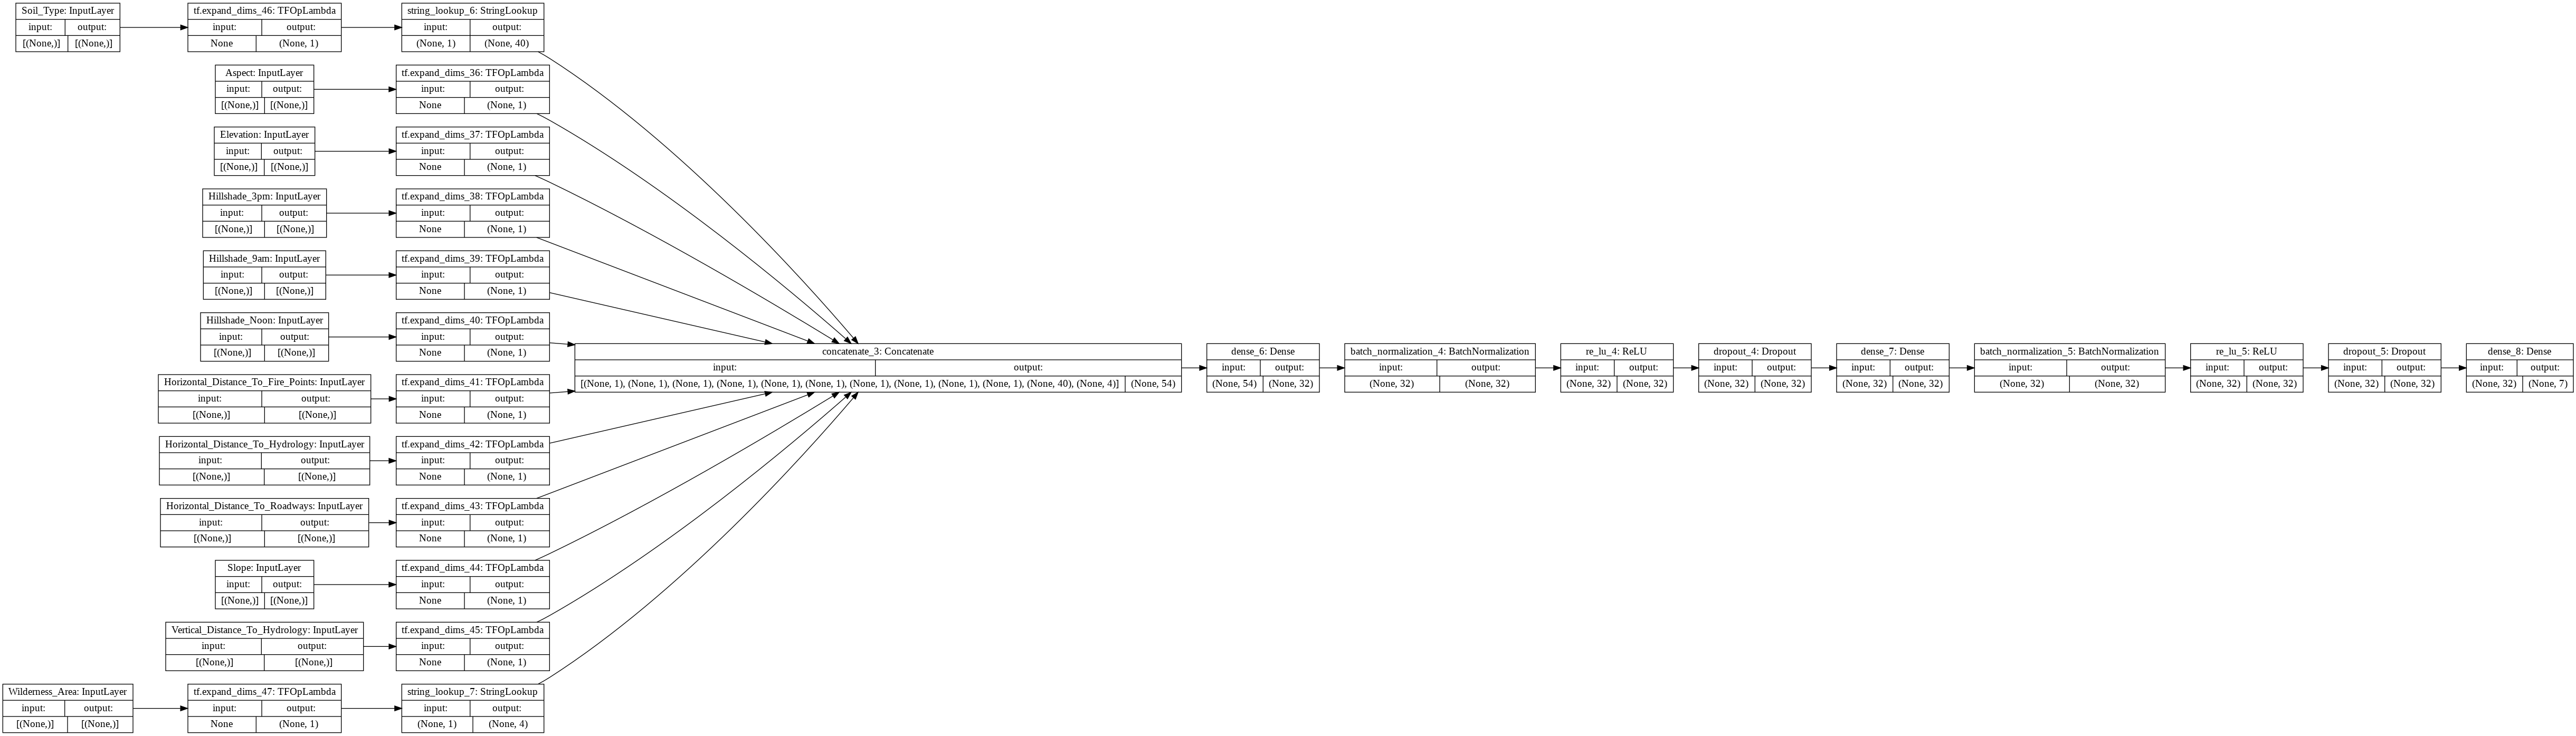

In [ ]:
baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [ ]:
# run_experiment Flow chart
# complie(loss fn, opt.. ) -> get_dataset_from_csv -> model fit -> eval -> result print
run_experiment(baseline_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 19s 10ms/step - loss: 0.7886 - sparse_categorical_accuracy: 0.6730
Epoch 2/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.6691 - sparse_categorical_accuracy: 0.7122
Epoch 3/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.7244
Epoch 4/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.6230 - sparse_categorical_accuracy: 0.7338
Epoch 5/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.6074 - sparse_categorical_accuracy: 0.7395
Epoch 6/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5973 - sparse_categorical_accuracy: 0.7436
Epoch 7/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.5904 - sparse_categorical_accuracy: 0.7457
Epoch 8/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.5862 - sparse_categorical_accuracy: 0.

    Baseline linear modeld은 평가 데이터에 대해서 약 78%의 정확도 성능을 보임

## Experiment 2: Wide & Deep model

Memorization과 Generalization의 장점을 결합하기 위해 Wide model과 Deep model을 공통으로 학습시키는 Wide & Deep model을 소개함.  

Wide model은 linear model이며 Deep model은 multi-layer feed-forward network로 구성됨.
 
    - Wide model은 입력 변수의 희소 표현(sparse representation)을 통해 변수들간의 상호작용을 효과적으로 학습.(Memorization)
    - Deep model은 입력 변수의 밀집 표현(dense representation)을 통해 일반화 성능을 극대화시킴.(Generalizaton)

모든 입력 변수는 동일하나 서로 다른 표현 방식을 통해 wide model과 deep model에 사용됨.

!["Wide & Deep model structure"](https://tensorflowkorea.files.wordpress.com/2016/06/image04.png)

In [ ]:
def create_wide_and_deep_model():

    # Define input data type & shape & size 
    inputs = create_model_inputs()
    
    # Modeling
    # 1) wide model = 희소 표현(sparse representation) 사용(one-hot encoding)
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    # Modeling
    # 2) deep model = 밀집 표현(dense representation) 사용(embedding)
    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    # wide & deep concat
    merged = layers.concatenate([wide, deep])

    # output
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)

    # model build
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

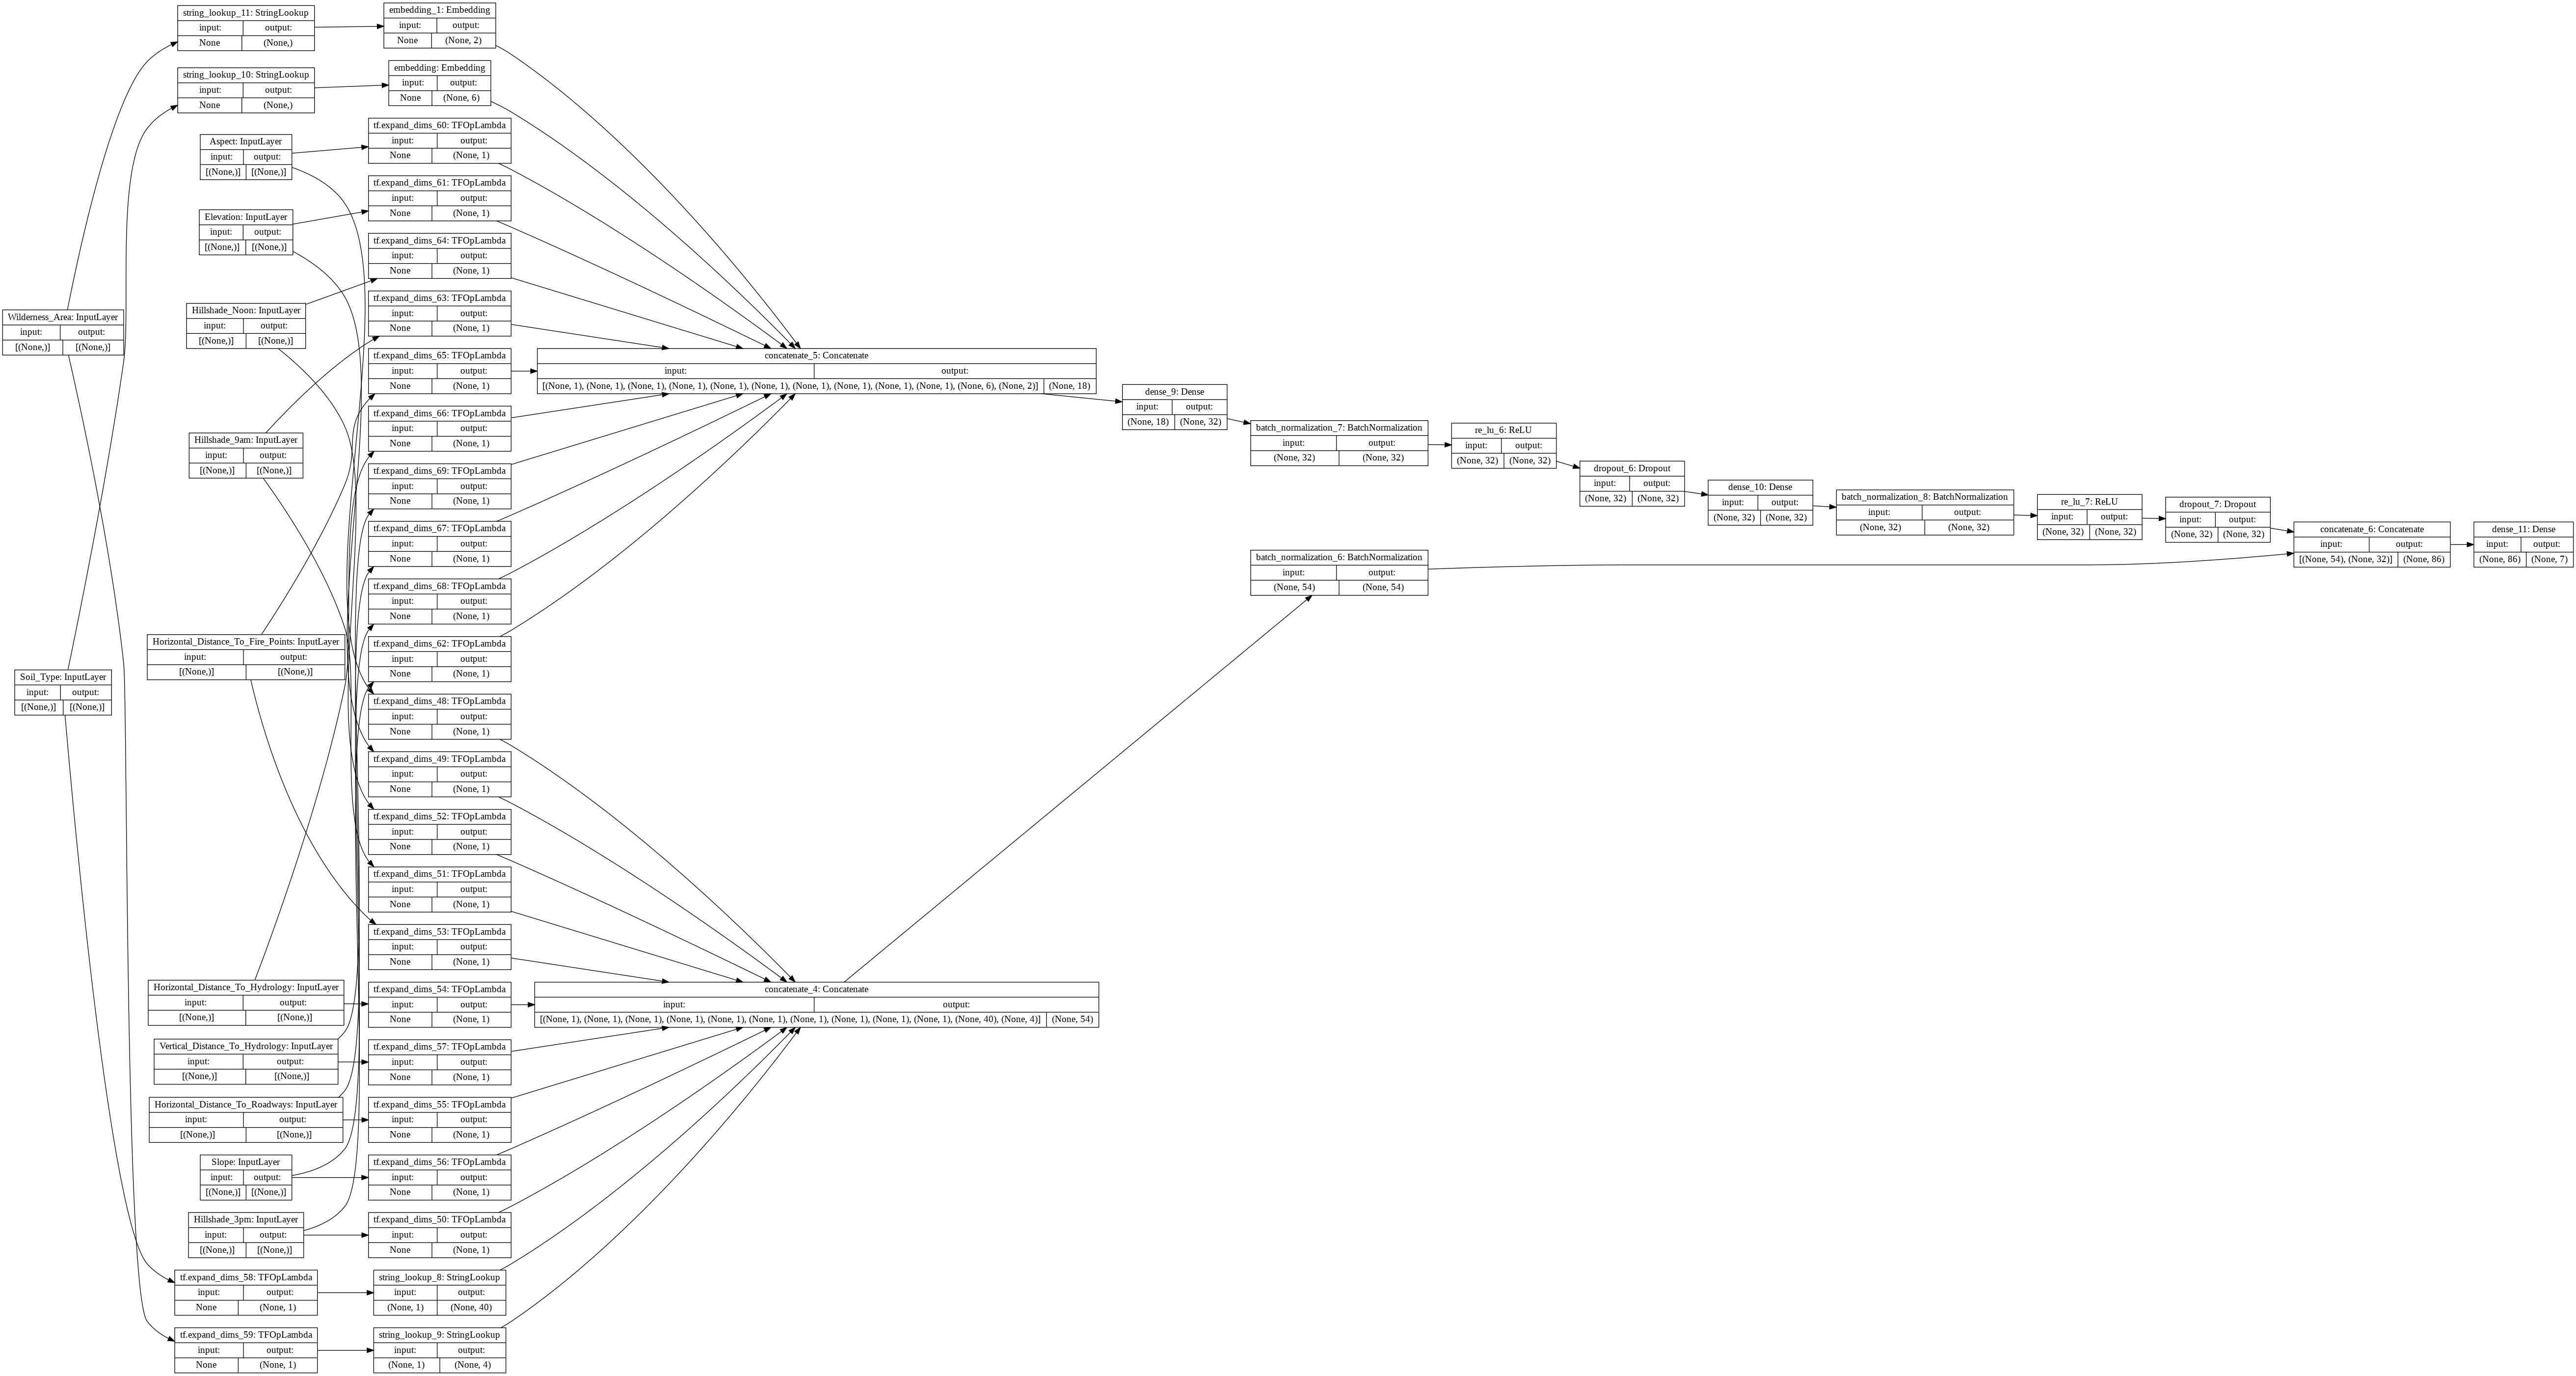

In [ ]:
wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [ ]:
# run_experiment Flow chart
# complie(loss fn, opt.. ) -> get_dataset_from_csv -> model fit -> eval -> result print
run_experiment(wide_and_deep_model)

Start training the model...
Epoch 1/50
1864/1864 [==============================] - 25s 12ms/step - loss: 0.7047 - sparse_categorical_accuracy: 0.7050
Epoch 2/50
1864/1864 [==============================] - 16s 9ms/step - loss: 0.6037 - sparse_categorical_accuracy: 0.7376
Epoch 3/50
1864/1864 [==============================] - 16s 9ms/step - loss: 0.5880 - sparse_categorical_accuracy: 0.7437
Epoch 4/50
1864/1864 [==============================] - 16s 9ms/step - loss: 0.5749 - sparse_categorical_accuracy: 0.7492
Epoch 5/50
1864/1864 [==============================] - 17s 9ms/step - loss: 0.5659 - sparse_categorical_accuracy: 0.7532
Epoch 6/50
1864/1864 [==============================] - 16s 9ms/step - loss: 0.5585 - sparse_categorical_accuracy: 0.7573
Epoch 7/50
1864/1864 [==============================] - 16s 9ms/step - loss: 0.5529 - sparse_categorical_accuracy: 0.7599
Epoch 8/50
1864/1864 [==============================] - 16s 9ms/step - loss: 0.5490 - sparse_categorical_accuracy: 0.

    Wide & Deep model은 평가 데이터에 대해서 약 80%의 정확도 성능을 보임

## Experiment 3: Deep & Cross model(Parallel)

Deep model은 이전 모델과 동일한 구조로 생성함.  
Deep & Cross model의 핵심은 layer depth와 cross 변수들의 차수가 커질수록 explicit 변수들의 교차를 효율적으로 적용하는 것이다.

<img src="http://drive.google.com/uc?export=view&id=1WtDUCV6b-eetUnWVCAmcPh8mJFut5EUd" width="600">

In [ ]:
def create_deep_and_cross_parallel_model():
    
    # Define input data type & shape & size 
    inputs = create_model_inputs()
    
    # Modeling
    # 1) cross model
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0 # Cross = Xi
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    # Modeling
    # 2) deep model
    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    # cross & deep concat
    merged = layers.concatenate([cross, deep])

    # output
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    
    # model build
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

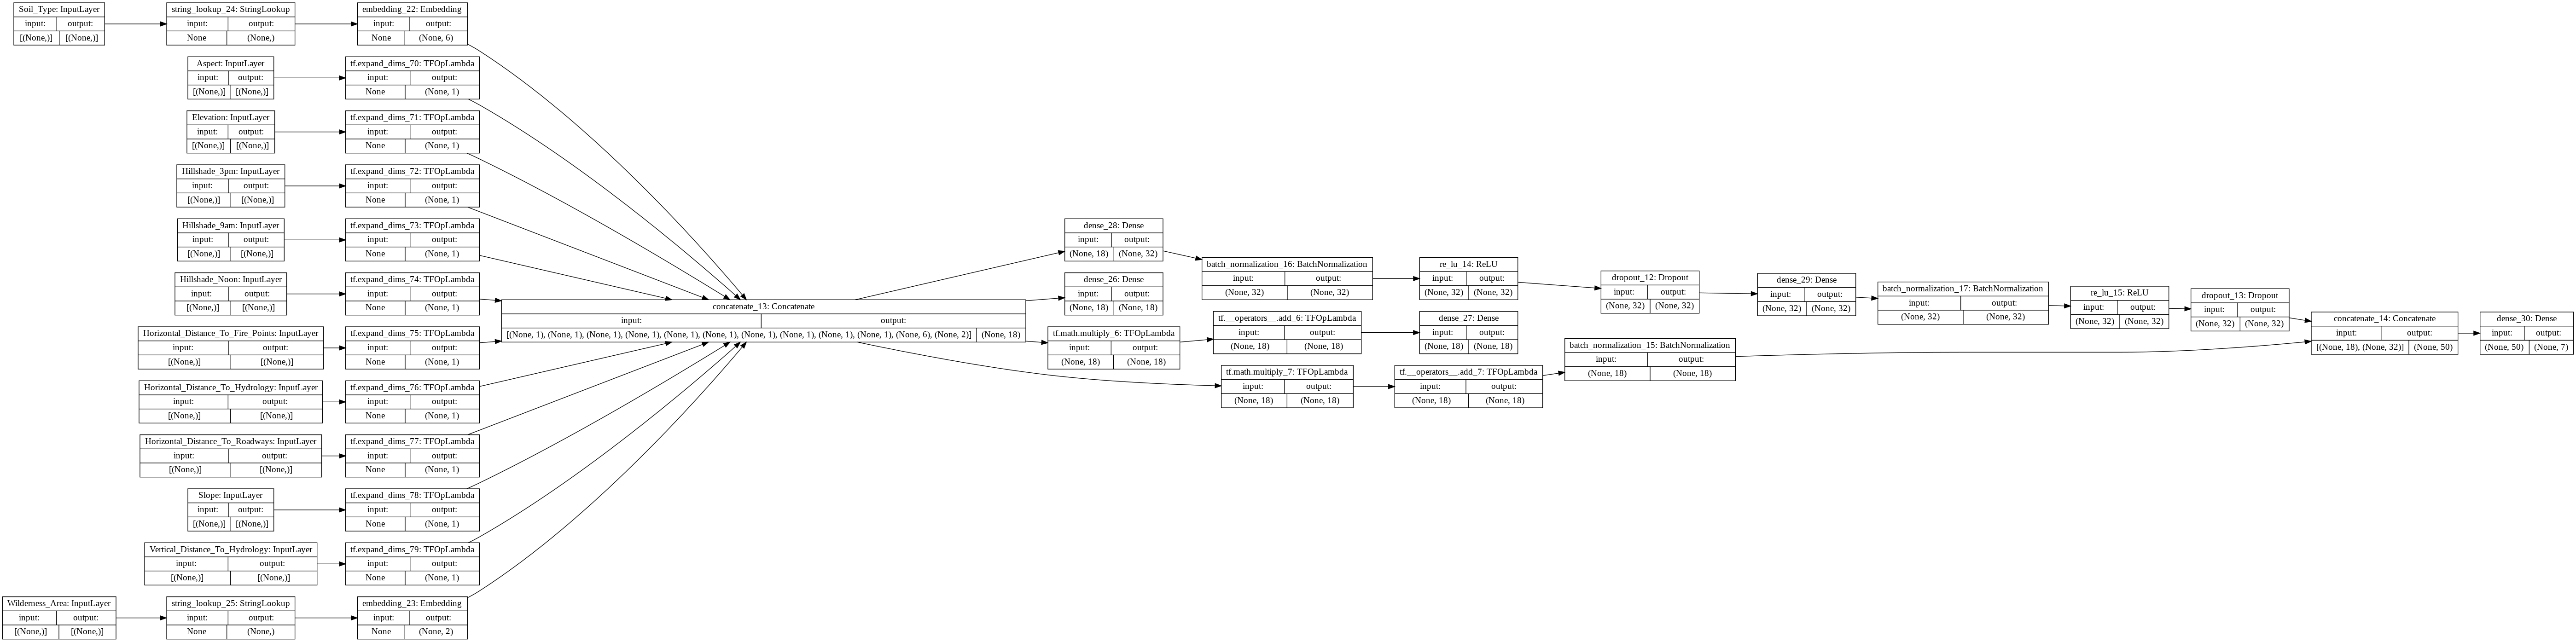

In [ ]:
deep_and_cross_paraller_model = create_deep_and_cross_parallel_model()
keras.utils.plot_model(deep_and_cross_paraller_model, show_shapes=True, rankdir="LR")

In [ ]:
# run_experiment Flow chart
# complie(loss fn, opt.. ) -> get_dataset_from_csv -> model fit -> eval -> result print
run_experiment(deep_and_cross_paraller_model)

Start training the model...
Epoch 1/2
1864/1864 [==============================] - 17s 8ms/step - loss: 0.6920 - sparse_categorical_accuracy: 0.7118
Epoch 2/2
1864/1864 [==============================] - 7s 4ms/step - loss: 0.5920 - sparse_categorical_accuracy: 0.7444
Model training finished
Test accuracy: 75.74%


    Deep & Cross paraller model은 평가 데이터에 대해서 약 81%의 정확도 성능을 보임

## 모델 해석

모델 학습을 통해 어떤 특성 교차가 중요한 특성인지 살펴보기 위해 weight를 가져와 heatmap으로 살펴봄.  
각 셀별 가중치는 교차되는 변수들 간의 상호 작용에 대해 학습된 중요성을 나타냄.  
`Embedding` layer를 통해 저차원 특성으로 표현된 변수들은 순서에 따라 변수명을 부여함.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 


# cross layer weight append
weight_list = []
in_shape = K.shape(deep_and_cross_paraller_model.variables[2]).numpy()[0]

for i in deep_and_cross_paraller_model.variables:
    if (len(K.shape(i).numpy())==2):
        if (K.shape(i).numpy()[0] == in_shape) & (K.shape(i).numpy()[1] == in_shape):
            weight_list.append(i)
        else:
            continue
    else:
        continue


# Feature names
FEATURE_NAME_LIST = []
for FEATURE in FEATURE_NAMES:
    if FEATURE not in CATEGORICAL_FEATURE_NAMES:
        FEATURE_NAME_LIST.append(FEATURE)
    else:
        embedding_dims = int(math.sqrt(len(data[FEATURE].unique())))
        [FEATURE_NAME_LIST.append(FEATURE+"_"+str(num)) for num in range(1, embedding_dims+1)]


# Weight df
cross_weight_df = pd.DataFrame(
                               weight_list[0].numpy(), 
                               columns = FEATURE_NAME_LIST,
                               index = FEATURE_NAME_LIST,
                               )

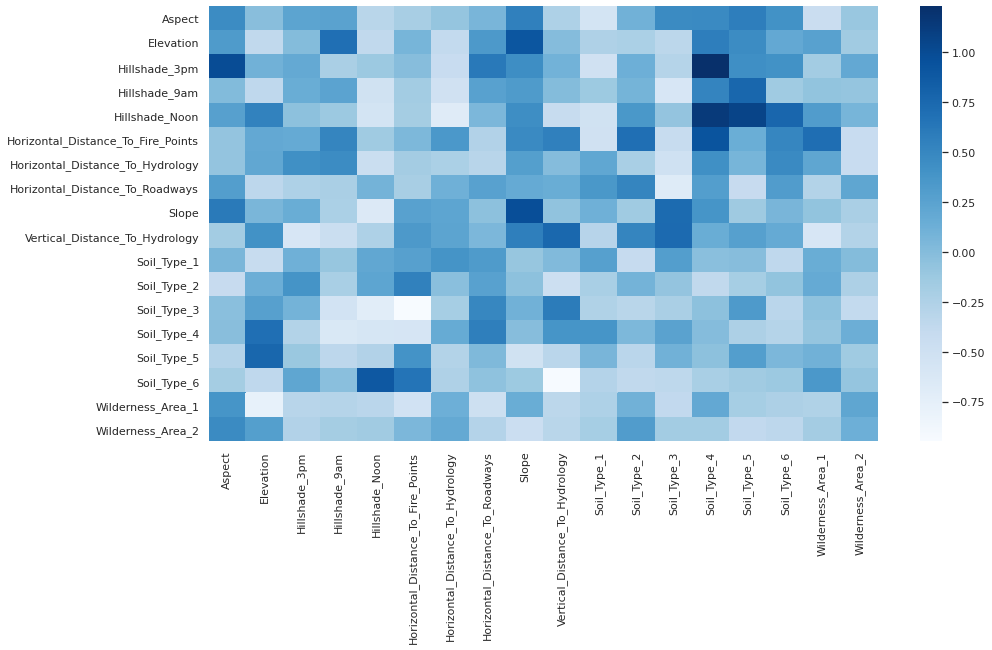

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cross_weight_df, cmap = plt.cm.Blues)
plt.show()

## Experiment 4: Deep & Cross model(Stack)

Deep & Cross model을 Stacked 구조로 학습할 경우 Cross network 출력값을 deep network의 입력값으로 넣어 진행.  
학습하는 데이터셋의 따라 Parallel 구조와 Stacked 구조의 성능 차이가 발생할 수 있음.

<img src="http://drive.google.com/uc?export=view&id=1xo_twKb847hasfss7JxF0UtFX_rEb4nt" width="400">

In [ ]:
def create_deep_and_cross_stack_model():
    
    # Define input data type & shape & size 
    inputs = create_model_inputs()
    
    # Modeling
    # 1) cross model
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0 # Cross = Xi
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)
    cross = layers.ReLU()(cross)

    # Modeling
    # 2) deep model
    deep = cross
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    # output
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(deep)
    
    # model build
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

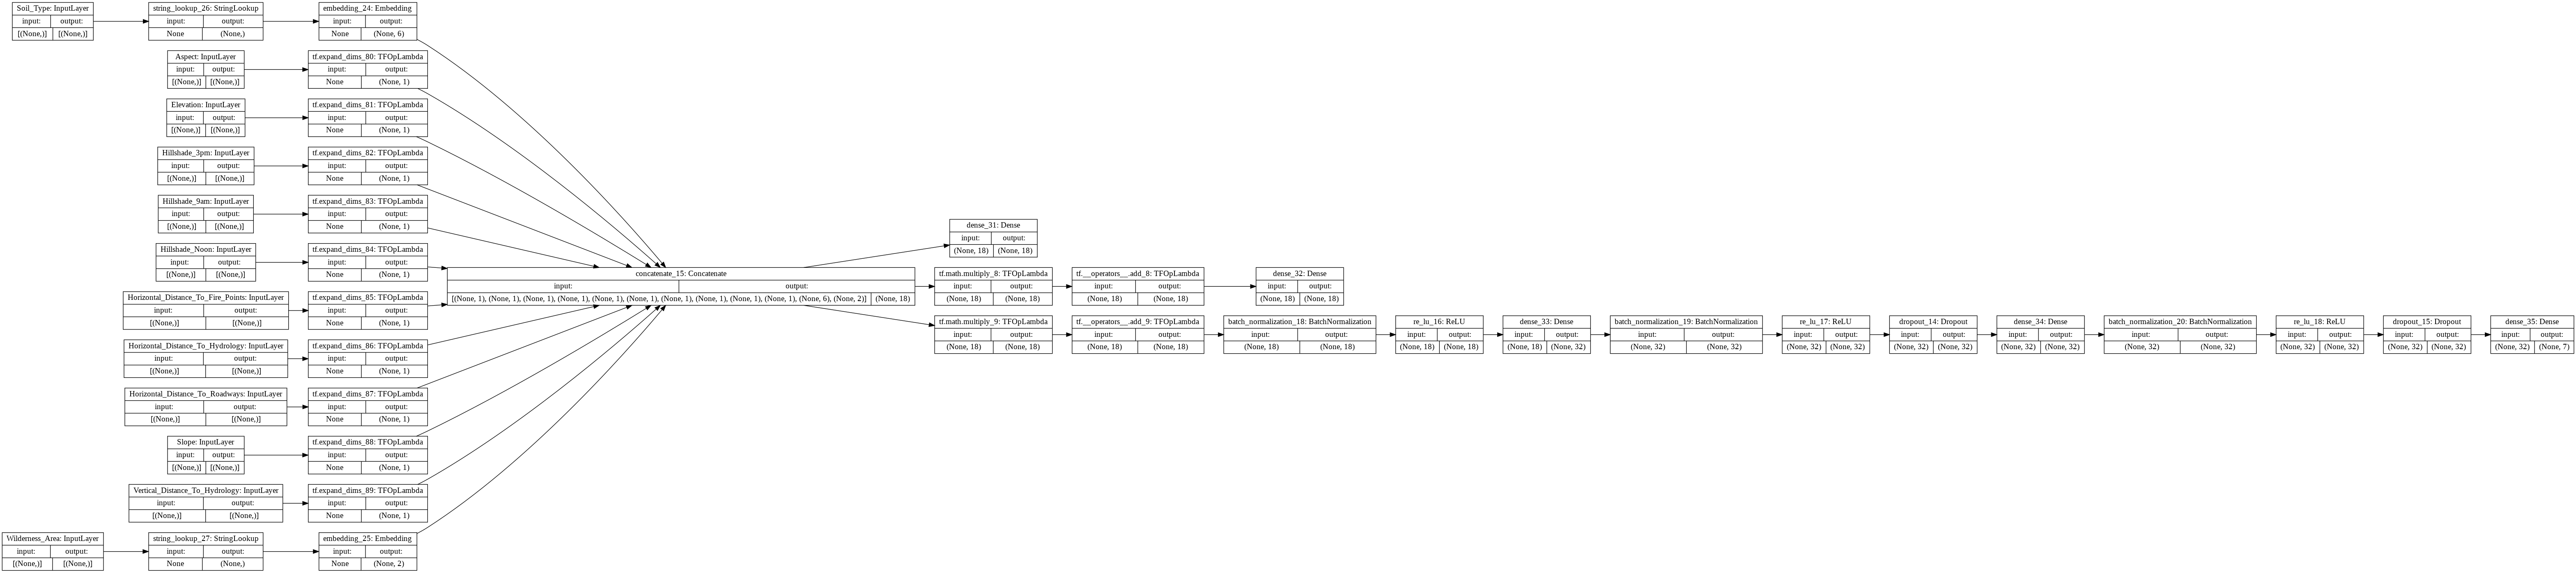

In [ ]:
deep_and_cross_stack_model = create_deep_and_cross_stack_model()
keras.utils.plot_model(deep_and_cross_stack_model, show_shapes=True, rankdir="LR")

In [ ]:
# run_experiment Flow chart
# complie(loss fn, opt.. ) -> get_dataset_from_csv -> model fit -> eval -> result print
run_experiment(deep_and_cross_stack_model)

Start training the model...
Epoch 1/2
1864/1864 [==============================] - 16s 8ms/step - loss: 0.7359 - sparse_categorical_accuracy: 0.7002
Epoch 2/2
1864/1864 [==============================] - 7s 4ms/step - loss: 0.6030 - sparse_categorical_accuracy: 0.7452
Model training finished
Test accuracy: 77.05%


    Wide & Deep stack model은 평가 데이터에 대해서 약 81%의 정확도 성능을 보임

## 모델 해석

모델 학습을 통해 어떤 특성 교차가 중요한 특성인지 살펴보기 위해 weight를 가져와 heatmap으로 살펴봄.  
각 셀별 가중치는 교차되는 변수들 간의 상호 작용에 대해 학습된 중요성을 나타냄.  
`Embedding` layer를 통해 저차원 특성으로 표현된 변수들은 순서에 따라 변수명을 부여함.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 


# cross layer weight append
weight_list = []
in_shape = K.shape(deep_and_cross_stack_model.variables[2]).numpy()[0]

for i in deep_and_cross_stack_model.variables:
    if (len(K.shape(i).numpy())==2):
        if (K.shape(i).numpy()[0] == in_shape) & (K.shape(i).numpy()[1] == in_shape):
            weight_list.append(i)
        else:
            continue
    else:
        continue


# Feature names
FEATURE_NAME_LIST = []
for FEATURE in FEATURE_NAMES:
    if FEATURE not in CATEGORICAL_FEATURE_NAMES:
        FEATURE_NAME_LIST.append(FEATURE)
    else:
        embedding_dims = int(math.sqrt(len(data[FEATURE].unique())))
        [FEATURE_NAME_LIST.append(FEATURE+"_"+str(num)) for num in range(1, embedding_dims+1)]


# Weight df
cross_weight_df = pd.DataFrame(
                               weight_list[0].numpy(), 
                               columns = FEATURE_NAME_LIST,
                               index = FEATURE_NAME_LIST,
                               )

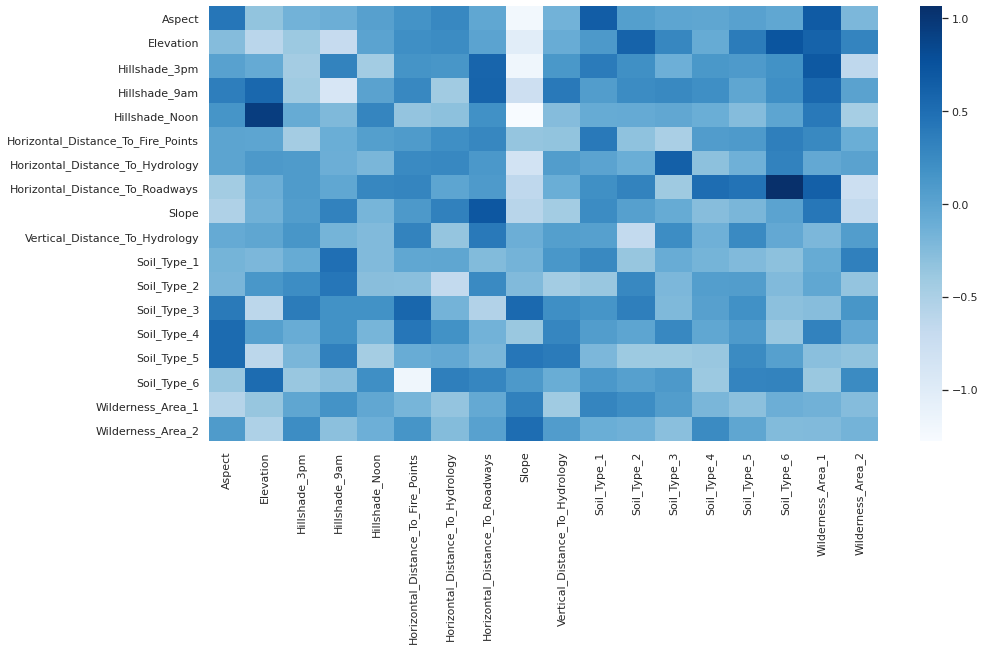

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cross_weight_df, cmap = plt.cm.Blues)
plt.show()

## Conclusion

Keras는 one-hot encoding, feature embedding과 같은 categorical 변수를 Preprocessing Layer를 통해 보다 쉽게 가공할 수 있다.  
추가적으로 wide, deep, cross network들은 dataset 특성에 따락 서로 다른 장점을 가지고 있다.  
그래서 위의 모델링을 바탕으로 쉽고 빠르게 분석하고자 하는 dataset의 적합한 결과를 찾을 수 있을 것이다.